# Strain Stock gDNA Sequencing Analysis
## Seq Library: Plasmidsaurus_9-30-2025_P4CYGL_prelim

These are long reads only. I will go ahead with the analysis because we are starting the next SDL experiment in a few days and so we need answers to the following questions fast:

1. Absence of DAHP synthases.
2. Absence of background mutations.
3. Presence of rsf.
4. Presence of dgoA* construct
5. Identity of dgoA* (not best or Ecoli)
6. dgoA* in single copy
7. dgoA* in expected location.



## Steps

1. Nanopore assembly (3, 4, 5, 6)
2. QC
3. Breseq against ADP1 (answers 1, 2)
4. Breseq against ACN2821 (answers 5, 6, 7)
5. Cannot assess 7 with 100% confidence: Need properly annotated assembly.


## Nanopore assemblies

- dgoA-Star present in single copy in contigs of all three colonies.
- rsfS present in contigs of all three colonies.

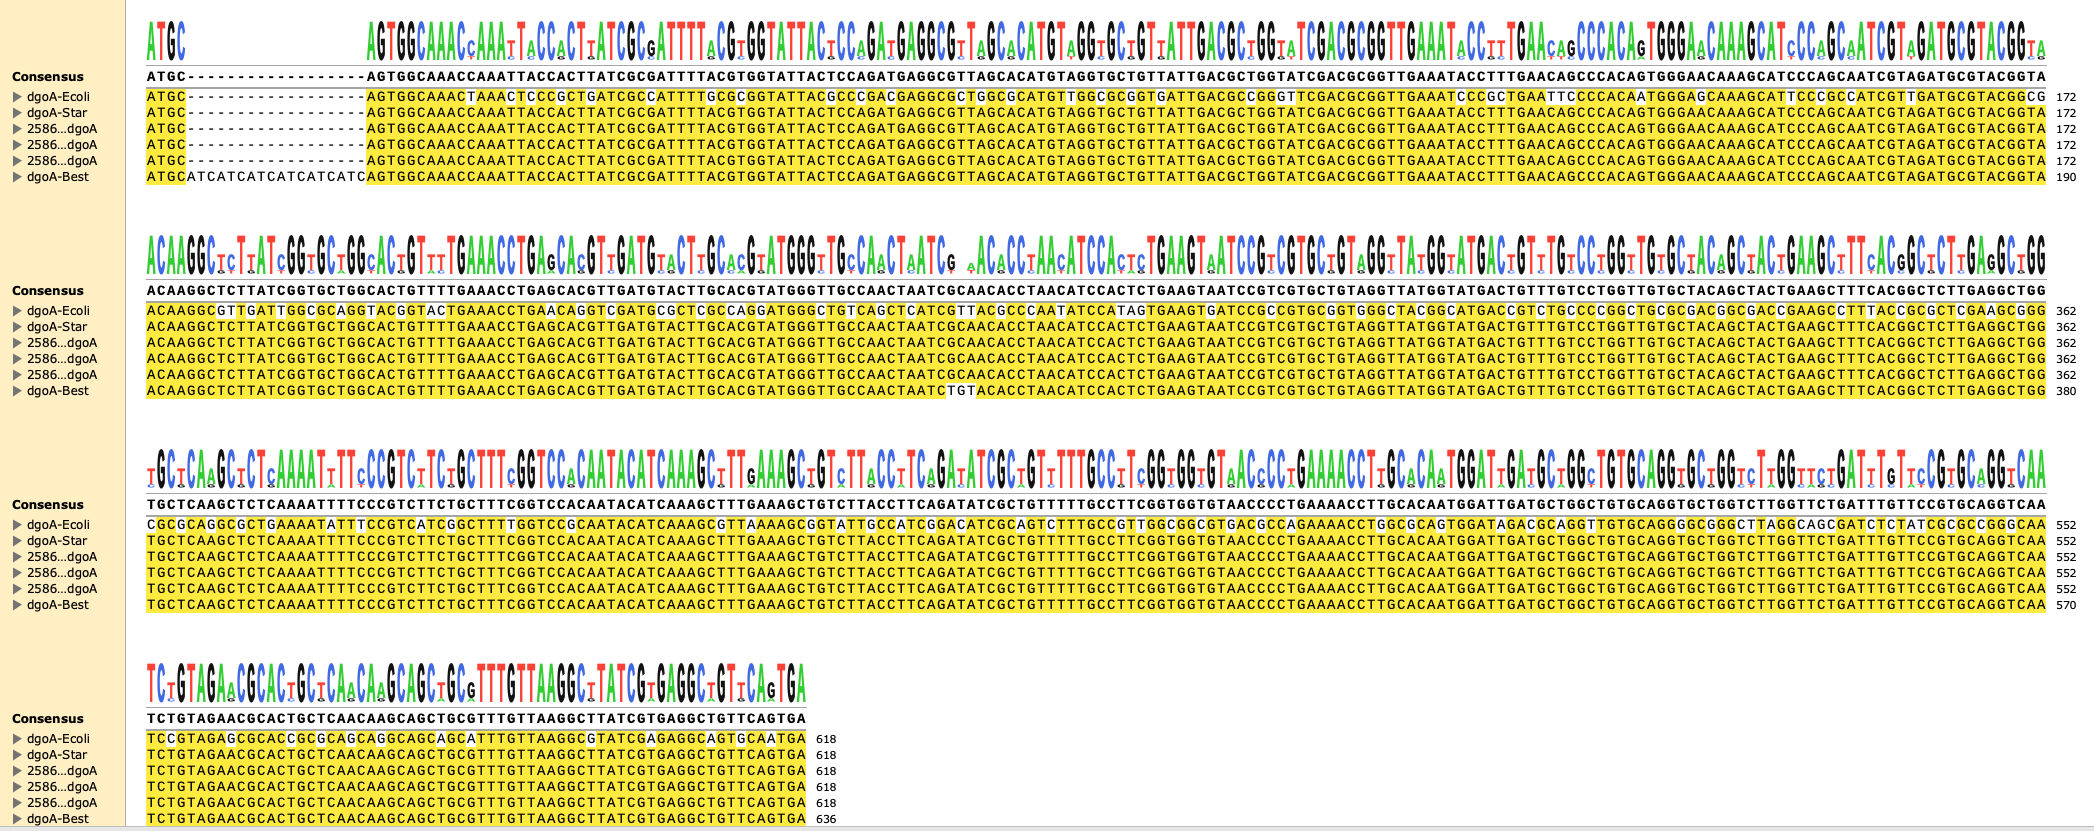

In [1]:
## Necessary for running locally (Natascha's laptop)
## Make sure running in appropriate environement

import sys

sys.path.append('/Users/nataschaspahr/code/ai_synbio_data_processing')

In [2]:
%load_ext autoreload
%autoreload 2

## Long Reads: QC

In [ ]:
## Running nanocomp (have to activate nanocomp_env first. Some incompatibility with tool in bre_env)

In [3]:
import pandas as pd
from binfo_utils import create_manifest
import os

base_dir = '/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim'
long_reads_dir = os.path.join(base_dir, 'long_reads')
received = os.path.join(long_reads_dir, 'received_fastq')
manifest = create_manifest(received, platform='plasmidsaurus_hybrid')
manifest

,sample_name,nanopore_fastq
0,ANLstock.ACN2586.colony1,/Users/nataschaspahr/data/seq_data/Plasmidsaur...
2,ANLstock.ACN2586.colony2,/Users/nataschaspahr/data/seq_data/Plasmidsaur...
1,ANLstock.ACN2586.colony3,/Users/nataschaspahr/data/seq_data/Plasmidsaur...


In [4]:
from read_qc import run_nanocomp

manifest = create_manifest(received, platform='plasmidsaurus_hybrid')

run_nanocomp(
    manifest['nanopore_fastq'].to_list(),
    manifest['sample_name'].to_list(),
    os.path.join(received, 'nanocomp_reports'),
    threads=10)

In [5]:
from read_qc import run_filtlong

filtered = os.path.join(long_reads_dir, 'filtered')
os.makedirs(filtered, exist_ok=True)

[run_filtlong(f, filtered, min_length=1000, keep_percent=90) for f in manifest['nanopore_fastq']]

Running filtlong on /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/received_fastq/ANLstock.ACN2586.colony1_nanopore.fastq.gz, output will be saved to /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered
Running filtlong on /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/received_fastq/ANLstock.ACN2586.colony2_nanopore.fastq.gz, output will be saved to /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered
Running filtlong on /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/received_fastq/ANLstock.ACN2586.colony3_nanopore.fastq.gz, output will be saved to /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered


['/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered/ANLstock.ACN2586.colony1_nanopore_filtered.fastq.gz',
 '/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered/ANLstock.ACN2586.colony2_nanopore_filtered.fastq.gz',
 '/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered/ANLstock.ACN2586.colony3_nanopore_filtered.fastq.gz']

In [6]:
from read_qc import run_nanocomp

manifest = create_manifest(filtered, platform='plasmidsaurus_hybrid')

run_nanocomp(
    manifest['nanopore_fastq'].to_list(),
    manifest['sample_name'].to_list(),
    os.path.join(filtered, 'nanocomp_reports'),
    threads=10)

## Long reads: Breseq

In [1]:
## Necessary for running locally (Natascha's laptop)
## Make sure running in appropriate environement

import sys

sys.path.append('/Users/nataschaspahr/code/ai_synbio_data_processing')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from binfo_utils import create_manifest
import os

base_dir = '/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim'
long_reads_dir = os.path.join(base_dir, 'long_reads')
received = os.path.join(long_reads_dir, 'received_fastq')
filtered = os.path.join(long_reads_dir, 'filtered')
manifest = create_manifest(filtered, platform='plasmidsaurus_hybrid')
manifest

,sample_name,nanopore_fastq
2,ANLstock.ACN2586.colony1,/Users/nataschaspahr/data/seq_data/Plasmidsaur...
0,ANLstock.ACN2586.colony2,/Users/nataschaspahr/data/seq_data/Plasmidsaur...
1,ANLstock.ACN2586.colony3,/Users/nataschaspahr/data/seq_data/Plasmidsaur...


### Breseq against ADP1

In [4]:
import os
from breseq import run_breseq

reference = '/Users/nataschaspahr/Reference_DBs/genomes/ADP1_Neidle_CDM.gbk'

for _, row in manifest.iterrows():
    out_dir = os.path.join(long_reads_dir, 'breseq', 'ADP1_Neidle_CDM', row['sample_name'])
    os.makedirs(out_dir, exist_ok=True)
    nanopore_fastq = row['nanopore_fastq']

    run_breseq(reference,
            out_dir,
            nanopore_fastq,
            '--long-read-split-length', '150',
            '--long-read-distribute-remainder',
            polymorphism_prediction=False,
            fold_coverage=200
            )

Running breseq with command: breseq -r /Users/nataschaspahr/Reference_DBs/genomes/ADP1_Neidle_CDM.gbk /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered/ANLstock.ACN2586.colony1_nanopore_filtered.fastq.gz --long-read-split-length 150 --long-read-distribute-remainder --genbank-field-for-seq-id ACCESSION --output /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony1 -j 10 --limit-fold-coverage 200


breseq 0.39.0     http://barricklab.org/breseq

Active Developers: Barrick JE, Deatherage DE
Contact:           <jeffrey.e.barrick@gmail.com>

breseq is free software; you can redistribute it and/or modify it under the
terms the GNU General Public License as published by the Free Software 
Foundation; either version 2, or (at your option) any later version.

Copyright (c) 2008-2010 Michigan State University
Copyright (c) 2011-2022 The University of Texas at Austin

If you use breseq in your research, please cite:

  Deatherage, D.E., Barrick, J.E. (2014) Identification of mutations
  in laboratory-evolved microbes from next-generation sequencing
  data using breseq. Methods Mol. Biol. 1151: 165–188.

If you use structural variation (junction) predictions, please cite:

  Barrick, J.E., Colburn, G., Deatherage D.E., Traverse, C.C.,
  Strand, M.D., Borges, J.J., Knoester, D.B., Reba, A., Meyer, A.G. 
  (2014) Identifying structural variation in haploid microbial genomes 
  from short-rea

150 bases


+++   NOW PROCESSING Read alignment to reference genome
[system] bowtie2-build -q "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony1/data/reference.fasta" "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony1/02_reference_alignment/reference"
[system] bowtie2 -t --no-unal -p 10 -L 31 --ma 1 --mp 3 --np 0 --rdg 2,3 --rfg 2,3 --ignore-quals --local -i S,1,0.25 --score-min L,1,0.9 -k 2000 --reorder -x "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony1/02_reference_alignment/reference" -U "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony1/01_sequence_conversion/ANLstock.ACN2586.colony1_nanopore_filtered.converted.fastq" -S "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/

Preprocessing alignments.


    ALIGNED READ:100000
    ALIGNED READ:200000
    ALIGNED READ:300000
    ALIGNED READ:400000
    ALIGNED READ:500000
    ALIGNED READ:600000
    ALIGNED READ:700000
    ALIGNED READ:800000
    ALIGNED READ:900000
    ALIGNED READ:1000000
    ALIGNED READ:1100000
    ALIGNED READ:1200000
    ALIGNED READ:1300000
    ALIGNED READ:1400000
    ALIGNED READ:1500000
    ALIGNED READ:1600000
    ALIGNED READ:1700000
    ALIGNED READ:1800000
    ALIGNED READ:1900000
    ALIGNED READ:2000000
    ALIGNED READ:2100000
    ALIGNED READ:2200000
    ALIGNED READ:2300000
    ALIGNED READ:2400000
    ALIGNED READ:2500000
    ALIGNED READ:2600000
    ALIGNED READ:2700000
    ALIGNED READ:2800000
    ALIGNED READ:2900000
    ALIGNED READ:3000000
    ALIGNED READ:3100000
  Summary... 
  Aligned reads:                              3175394
  Read alignments:                            3487773
  Alignments split on indels:                   93664
  Reads with alignments split on indels:        85370
  Sp

Running breseq with command: breseq -r /Users/nataschaspahr/Reference_DBs/genomes/ADP1_Neidle_CDM.gbk /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered/ANLstock.ACN2586.colony2_nanopore_filtered.fastq.gz --long-read-split-length 150 --long-read-distribute-remainder --genbank-field-for-seq-id ACCESSION --output /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony2 -j 10 --limit-fold-coverage 200


breseq 0.39.0     http://barricklab.org/breseq

Active Developers: Barrick JE, Deatherage DE
Contact:           <jeffrey.e.barrick@gmail.com>

breseq is free software; you can redistribute it and/or modify it under the
terms the GNU General Public License as published by the Free Software 
Foundation; either version 2, or (at your option) any later version.

Copyright (c) 2008-2010 Michigan State University
Copyright (c) 2011-2022 The University of Texas at Austin

If you use breseq in your research, please cite:

  Deatherage, D.E., Barrick, J.E. (2014) Identification of mutations
  in laboratory-evolved microbes from next-generation sequencing
  data using breseq. Methods Mol. Biol. 1151: 165–188.

If you use structural variation (junction) predictions, please cite:

  Barrick, J.E., Colburn, G., Deatherage D.E., Traverse, C.C.,
  Strand, M.D., Borges, J.J., Knoester, D.B., Reba, A., Meyer, A.G. 
  (2014) Identifying structural variation in haploid microbial genomes 
  from short-rea

150 bases


+++   NOW PROCESSING Read alignment to reference genome
[system] bowtie2-build -q "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony2/data/reference.fasta" "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony2/02_reference_alignment/reference"
[system] bowtie2 -t --no-unal -p 10 -L 31 --ma 1 --mp 3 --np 0 --rdg 2,3 --rfg 2,3 --ignore-quals --local -i S,1,0.25 --score-min L,1,0.9 -k 2000 --reorder -x "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony2/02_reference_alignment/reference" -U "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony2/01_sequence_conversion/ANLstock.ACN2586.colony2_nanopore_filtered.converted.fastq" -S "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/

Preprocessing alignments.


    ALIGNED READ:100000
    ALIGNED READ:200000
    ALIGNED READ:300000
    ALIGNED READ:400000
    ALIGNED READ:500000
    ALIGNED READ:600000
    ALIGNED READ:700000
    ALIGNED READ:800000
    ALIGNED READ:900000
    ALIGNED READ:1000000
    ALIGNED READ:1100000
    ALIGNED READ:1200000
    ALIGNED READ:1300000
    ALIGNED READ:1400000
    ALIGNED READ:1500000
    ALIGNED READ:1600000
    ALIGNED READ:1700000
    ALIGNED READ:1800000
    ALIGNED READ:1900000
    ALIGNED READ:2000000
    ALIGNED READ:2100000
    ALIGNED READ:2200000
    ALIGNED READ:2300000
    ALIGNED READ:2400000
    ALIGNED READ:2500000
    ALIGNED READ:2600000
    ALIGNED READ:2700000
    ALIGNED READ:2800000
    ALIGNED READ:2900000
    ALIGNED READ:3000000
    ALIGNED READ:3100000
    ALIGNED READ:3200000
    ALIGNED READ:3300000
    ALIGNED READ:3400000
    ALIGNED READ:3500000
    ALIGNED READ:3600000
    ALIGNED READ:3700000
    ALIGNED READ:3800000
    ALIGNED READ:3900000
    ALIGNED READ:4000000
    ALIGN

Running breseq with command: breseq -r /Users/nataschaspahr/Reference_DBs/genomes/ADP1_Neidle_CDM.gbk /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered/ANLstock.ACN2586.colony3_nanopore_filtered.fastq.gz --long-read-split-length 150 --long-read-distribute-remainder --genbank-field-for-seq-id ACCESSION --output /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony3 -j 10 --limit-fold-coverage 200


breseq 0.39.0     http://barricklab.org/breseq

Active Developers: Barrick JE, Deatherage DE
Contact:           <jeffrey.e.barrick@gmail.com>

breseq is free software; you can redistribute it and/or modify it under the
terms the GNU General Public License as published by the Free Software 
Foundation; either version 2, or (at your option) any later version.

Copyright (c) 2008-2010 Michigan State University
Copyright (c) 2011-2022 The University of Texas at Austin

If you use breseq in your research, please cite:

  Deatherage, D.E., Barrick, J.E. (2014) Identification of mutations
  in laboratory-evolved microbes from next-generation sequencing
  data using breseq. Methods Mol. Biol. 1151: 165–188.

If you use structural variation (junction) predictions, please cite:

  Barrick, J.E., Colburn, G., Deatherage D.E., Traverse, C.C.,
  Strand, M.D., Borges, J.J., Knoester, D.B., Reba, A., Meyer, A.G. 
  (2014) Identifying structural variation in haploid microbial genomes 
  from short-rea

150 bases


+++   NOW PROCESSING Read alignment to reference genome
[system] bowtie2-build -q "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony3/data/reference.fasta" "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony3/02_reference_alignment/reference"
[system] bowtie2 -t --no-unal -p 10 -L 31 --ma 1 --mp 3 --np 0 --rdg 2,3 --rfg 2,3 --ignore-quals --local -i S,1,0.25 --score-min L,1,0.9 -k 2000 --reorder -x "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony3/02_reference_alignment/reference" -U "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ADP1/ANLstock.ACN2586.colony3/01_sequence_conversion/ANLstock.ACN2586.colony3_nanopore_filtered.converted.fastq" -S "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/

Preprocessing alignments.


    ALIGNED READ:100000
    ALIGNED READ:200000
    ALIGNED READ:300000
    ALIGNED READ:400000
    ALIGNED READ:500000
    ALIGNED READ:600000
    ALIGNED READ:700000
    ALIGNED READ:800000
    ALIGNED READ:900000
    ALIGNED READ:1000000
    ALIGNED READ:1100000
    ALIGNED READ:1200000
    ALIGNED READ:1300000
    ALIGNED READ:1400000
    ALIGNED READ:1500000
    ALIGNED READ:1600000
    ALIGNED READ:1700000
    ALIGNED READ:1800000
    ALIGNED READ:1900000
    ALIGNED READ:2000000
    ALIGNED READ:2100000
    ALIGNED READ:2200000
    ALIGNED READ:2300000
    ALIGNED READ:2400000
  Summary... 
  Aligned reads:                              2473601
  Read alignments:                            2749759
  Alignments split on indels:                   79038
  Reads with alignments split on indels:        71137
  Split alignments:                            184558
  Reads with split alignments:                  76440
+++   NOW PROCESSING Preliminary analysis of coverage distribution
[sam

### Breseq against ACN2821

In [8]:
import os
from breseq import run_breseq

reference = '/Users/nataschaspahr/Reference_DBs/genomes/ACN2821_CDM.gbk'

for _, row in manifest.iterrows():
    out_dir = os.path.join(long_reads_dir, 'breseq', 'ACN2821_CDM', row['sample_name'])
    os.makedirs(out_dir, exist_ok=True)
    nanopore_fastq = row['nanopore_fastq']

    run_breseq(reference,
            out_dir,
            nanopore_fastq,
            '--long-read-split-length', '150',
            '--long-read-distribute-remainder',
            polymorphism_prediction=False,
            fold_coverage=200
            )

Running breseq with command: breseq -r /Users/nataschaspahr/Reference_DBs/genomes/ACN2821_CDM.gbk /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered/ANLstock.ACN2586.colony1_nanopore_filtered.fastq.gz --long-read-split-length 150 --long-read-distribute-remainder --genbank-field-for-seq-id ACCESSION --output /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ACN2821_CDM/ANLstock.ACN2586.colony1 -j 10 --limit-fold-coverage 200


breseq 0.39.0     http://barricklab.org/breseq

Active Developers: Barrick JE, Deatherage DE
Contact:           <jeffrey.e.barrick@gmail.com>

breseq is free software; you can redistribute it and/or modify it under the
terms the GNU General Public License as published by the Free Software 
Foundation; either version 2, or (at your option) any later version.

Copyright (c) 2008-2010 Michigan State University
Copyright (c) 2011-2022 The University of Texas at Austin

If you use breseq in your research, please cite:

  Deatherage, D.E., Barrick, J.E. (2014) Identification of mutations
  in laboratory-evolved microbes from next-generation sequencing
  data using breseq. Methods Mol. Biol. 1151: 165–188.

If you use structural variation (junction) predictions, please cite:

  Barrick, J.E., Colburn, G., Deatherage D.E., Traverse, C.C.,
  Strand, M.D., Borges, J.J., Knoester, D.B., Reba, A., Meyer, A.G. 
  (2014) Identifying structural variation in haploid microbial genomes 
  from short-rea

150 bases


----------------------------------> WARNING <-----------------------------------
CDS feature(s) found with nucleotide length(s) that are not a multiple of 3:
ACIAD_RS05600 (sohB), ACIAD_RS10750 (ACIAD_RS10750)

Translations of mutations in these genes may be incorrect.
It is recommended that you fix these feature annotations in your reference file!
Another solution is to mark them as pseudogenes:
  GenBank: add '/pseudo' as a new line within the CDS feature
  GFF3: add 'Pseudo=true' to the semicolon-separated list at the end of the CDS line.
--------------------------------------------------------------------------------
+++   NOW PROCESSING Read alignment to reference genome
[system] bowtie2-build -q "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ACN2821_CDM/ANLstock.ACN2586.colony1/data/reference.fasta" "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ACN2821_CDM/ANLstock.ACN2586.colony1/02_refere

Preprocessing alignments.


    ALIGNED READ:100000
    ALIGNED READ:200000
    ALIGNED READ:300000
    ALIGNED READ:400000
    ALIGNED READ:500000
    ALIGNED READ:600000
    ALIGNED READ:700000
    ALIGNED READ:800000
    ALIGNED READ:900000
    ALIGNED READ:1000000
    ALIGNED READ:1100000
    ALIGNED READ:1200000
    ALIGNED READ:1300000
    ALIGNED READ:1400000
    ALIGNED READ:1500000
    ALIGNED READ:1600000
    ALIGNED READ:1700000
    ALIGNED READ:1800000
    ALIGNED READ:1900000
    ALIGNED READ:2000000
    ALIGNED READ:2100000
    ALIGNED READ:2200000
    ALIGNED READ:2300000
    ALIGNED READ:2400000
    ALIGNED READ:2500000
    ALIGNED READ:2600000
    ALIGNED READ:2700000
    ALIGNED READ:2800000
    ALIGNED READ:2900000
    ALIGNED READ:3000000
    ALIGNED READ:3100000
  Summary... 
  Aligned reads:                              3177132
  Read alignments:                            3489508
  Alignments split on indels:                   93738
  Reads with alignments split on indels:        85438
  Sp

Running breseq with command: breseq -r /Users/nataschaspahr/Reference_DBs/genomes/ACN2821_CDM.gbk /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered/ANLstock.ACN2586.colony2_nanopore_filtered.fastq.gz --long-read-split-length 150 --long-read-distribute-remainder --genbank-field-for-seq-id ACCESSION --output /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ACN2821_CDM/ANLstock.ACN2586.colony2 -j 10 --limit-fold-coverage 200


---> bowtie2  :: version 2.5.4 [/opt/anaconda3/envs/bre_env/bin/bowtie2]
---> bowtie2  :: NOTE :: breseq output may vary slightly depending on your bowtie2 version,
---> bowtie2  :: NOTE :: and occasionally bowtie2 versions may have bugs that cause crashes.
---> bowtie2  :: NOTE :: bowtie2 version 2.4.5 is recommended with this breseq version.
---> R        :: version 4.4.2 [/opt/anaconda3/envs/bre_env/bin/R]
+++   NOW PROCESSING Read and reference sequence file input
----------------------------------> WARNING <-----------------------------------
Length assigned to sequence 'NC_005966' from LOCUS line (3599271) does not match length previously assigned from source feature (1680319). The larger of the two lengths will be used. If you encounter further errors, make sure LOCUS lengths match the true lengths of your DNA sequences.
--------------------------------------------------------------------------------
----------------------------------> WARNING <----------------------------------

150 bases


----------------------------------> WARNING <-----------------------------------
CDS feature(s) found with nucleotide length(s) that are not a multiple of 3:
ACIAD_RS05600 (sohB), ACIAD_RS10750 (ACIAD_RS10750)

Translations of mutations in these genes may be incorrect.
It is recommended that you fix these feature annotations in your reference file!
Another solution is to mark them as pseudogenes:
  GenBank: add '/pseudo' as a new line within the CDS feature
  GFF3: add 'Pseudo=true' to the semicolon-separated list at the end of the CDS line.
--------------------------------------------------------------------------------
+++   NOW PROCESSING Read alignment to reference genome
[system] bowtie2-build -q "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ACN2821_CDM/ANLstock.ACN2586.colony2/data/reference.fasta" "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ACN2821_CDM/ANLstock.ACN2586.colony2/02_refere

Preprocessing alignments.


    ALIGNED READ:100000
    ALIGNED READ:200000
    ALIGNED READ:300000
    ALIGNED READ:400000
    ALIGNED READ:500000
    ALIGNED READ:600000
    ALIGNED READ:700000
    ALIGNED READ:800000
    ALIGNED READ:900000
    ALIGNED READ:1000000
    ALIGNED READ:1100000
    ALIGNED READ:1200000
    ALIGNED READ:1300000
    ALIGNED READ:1400000
    ALIGNED READ:1500000
    ALIGNED READ:1600000
    ALIGNED READ:1700000
    ALIGNED READ:1800000
    ALIGNED READ:1900000
    ALIGNED READ:2000000
    ALIGNED READ:2100000
    ALIGNED READ:2200000
    ALIGNED READ:2300000
    ALIGNED READ:2400000
    ALIGNED READ:2500000
    ALIGNED READ:2600000
    ALIGNED READ:2700000
    ALIGNED READ:2800000
    ALIGNED READ:2900000
    ALIGNED READ:3000000
    ALIGNED READ:3100000
    ALIGNED READ:3200000
    ALIGNED READ:3300000
    ALIGNED READ:3400000
    ALIGNED READ:3500000
    ALIGNED READ:3600000
    ALIGNED READ:3700000
    ALIGNED READ:3800000
    ALIGNED READ:3900000
    ALIGNED READ:4000000
    ALIGN

Running breseq with command: breseq -r /Users/nataschaspahr/Reference_DBs/genomes/ACN2821_CDM.gbk /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/filtered/ANLstock.ACN2586.colony3_nanopore_filtered.fastq.gz --long-read-split-length 150 --long-read-distribute-remainder --genbank-field-for-seq-id ACCESSION --output /Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ACN2821_CDM/ANLstock.ACN2586.colony3 -j 10 --limit-fold-coverage 200


breseq 0.39.0     http://barricklab.org/breseq

Active Developers: Barrick JE, Deatherage DE
Contact:           <jeffrey.e.barrick@gmail.com>

breseq is free software; you can redistribute it and/or modify it under the
terms the GNU General Public License as published by the Free Software 
Foundation; either version 2, or (at your option) any later version.

Copyright (c) 2008-2010 Michigan State University
Copyright (c) 2011-2022 The University of Texas at Austin

If you use breseq in your research, please cite:

  Deatherage, D.E., Barrick, J.E. (2014) Identification of mutations
  in laboratory-evolved microbes from next-generation sequencing
  data using breseq. Methods Mol. Biol. 1151: 165–188.

If you use structural variation (junction) predictions, please cite:

  Barrick, J.E., Colburn, G., Deatherage D.E., Traverse, C.C.,
  Strand, M.D., Borges, J.J., Knoester, D.B., Reba, A., Meyer, A.G. 
  (2014) Identifying structural variation in haploid microbial genomes 
  from short-rea

150 bases


----------------------------------> WARNING <-----------------------------------
CDS feature(s) found with nucleotide length(s) that are not a multiple of 3:
ACIAD_RS05600 (sohB), ACIAD_RS10750 (ACIAD_RS10750)

Translations of mutations in these genes may be incorrect.
It is recommended that you fix these feature annotations in your reference file!
Another solution is to mark them as pseudogenes:
  GenBank: add '/pseudo' as a new line within the CDS feature
  GFF3: add 'Pseudo=true' to the semicolon-separated list at the end of the CDS line.
--------------------------------------------------------------------------------
+++   NOW PROCESSING Read alignment to reference genome
[system] bowtie2-build -q "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ACN2821_CDM/ANLstock.ACN2586.colony3/data/reference.fasta" "/Users/nataschaspahr/data/seq_data/Plasmidsaurus_9-30-2025_P4CYGL_prelim/long_reads/breseq/ACN2821_CDM/ANLstock.ACN2586.colony3/02_refere

Preprocessing alignments.


    ALIGNED READ:100000
    ALIGNED READ:200000
    ALIGNED READ:300000
    ALIGNED READ:400000
    ALIGNED READ:500000
    ALIGNED READ:600000
    ALIGNED READ:700000
    ALIGNED READ:800000
    ALIGNED READ:900000
    ALIGNED READ:1000000
    ALIGNED READ:1100000
    ALIGNED READ:1200000
    ALIGNED READ:1300000
    ALIGNED READ:1400000
    ALIGNED READ:1500000
    ALIGNED READ:1600000
    ALIGNED READ:1700000
    ALIGNED READ:1800000
    ALIGNED READ:1900000
    ALIGNED READ:2000000
    ALIGNED READ:2100000
    ALIGNED READ:2200000
    ALIGNED READ:2300000
    ALIGNED READ:2400000
  Summary... 
  Aligned reads:                              2474874
  Read alignments:                            2751035
  Alignments split on indels:                   79075
  Reads with alignments split on indels:        71171
  Split alignments:                            184565
  Reads with split alignments:                  76437
+++   NOW PROCESSING Preliminary analysis of coverage distribution
[sam

### Comparison tables

In [13]:
os.path.exists(old_gd_path)

False

In [14]:
os.path.exists(new_gd_path)

True

In [15]:
# Before doing the genome diff file comparison, must rename files so that they are named correctly in the html output
# Also, must replace '.' in file names, else everything after '.' is discarded

import os
from breseq import compare_gdiff

reference_files = [
    '/Users/nataschaspahr/Reference_DBs/genomes/ADP1_Neidle_CDM.gbk',
    '/Users/nataschaspahr/Reference_DBs/genomes/ACN2821_CDM.gbk'
    ]
samples = manifest['sample_name'].to_list()

for r in reference_files:
    reference = os.path.basename(r).replace('.gbk', '')
    gdiffs = []
    
    for sample in samples:
        old_gd_path = os.path.join(long_reads_dir, 'breseq', reference, sample, 'data/output.gd')
        new_gd_path = os.path.join(long_reads_dir, 'breseq', reference, sample, 'data/output.gd'.replace('output', sample.replace('.', '_')))
        gdiffs.append(new_gd_path)
        os.rename(old_gd_path, new_gd_path)
    
    compare_gdiff(
        r,
        os.path.join(long_reads_dir, 'breseq', reference + '_comparison.html'),
        gdiffs
    )

breseq 0.39.0     http://barricklab.org/breseq

Active Developers: Barrick JE, Deatherage DE
Contact:           <jeffrey.e.barrick@gmail.com>

breseq is free software; you can redistribute it and/or modify it under the
terms the GNU General Public License as published by the Free Software 
Foundation; either version 2, or (at your option) any later version.

Copyright (c) 2008-2010 Michigan State University
Copyright (c) 2011-2022 The University of Texas at Austin

If you use breseq in your research, please cite:

  Deatherage, D.E., Barrick, J.E. (2014) Identification of mutations
  in laboratory-evolved microbes from next-generation sequencing
  data using breseq. Methods Mol. Biol. 1151: 165–188.

If you use structural variation (junction) predictions, please cite:

  Barrick, J.E., Colburn, G., Deatherage D.E., Traverse, C.C.,
  Strand, M.D., Borges, J.J., Knoester, D.B., Reba, A., Meyer, A.G. 
  (2014) Identifying structural variation in haploid microbial genomes 
  from short-rea

### Amplicon copy number from coverage

In [16]:
from breseq import parse_region_average_cov_from_file, run_bam2cov

manifest['rpoA_locus_ACN2821'] = ['NC_005966:3122573-3123580']*3
manifest['dgoA_locus_ACN2821'] = ['NC_005966:1678034-1682709']*3
manifest['rpoA_cov'] = [None]*3
manifest['dgoA_cov'] = [None]*3
manifest

,sample_name,nanopore_fastq,rpoA_locus_ACN2821,dgoA_locus_ACN2821,rpoA_cov,dgoA_cov
2,ANLstock.ACN2586.colony1,/Users/nataschaspahr/data/seq_data/Plasmidsaur...,NC_005966:3122573-3123580,NC_005966:1678034-1682709,None,None
0,ANLstock.ACN2586.colony2,/Users/nataschaspahr/data/seq_data/Plasmidsaur...,NC_005966:3122573-3123580,NC_005966:1678034-1682709,None,None
1,ANLstock.ACN2586.colony3,/Users/nataschaspahr/data/seq_data/Plasmidsaur...,NC_005966:3122573-3123580,NC_005966:1678034-1682709,None,None


In [17]:

manifest['rpoA_cov'] = [
    parse_region_average_cov_from_file(
        run_bam2cov(
            os.path.join(long_reads_dir, 'breseq', 'ACN2821_CDM', row['sample_name']),
            row['rpoA_locus_ACN2821']))
    for _, row in manifest.iterrows()
]

manifest['dgoA_cov'] = [
    parse_region_average_cov_from_file(
        run_bam2cov(
            os.path.join(long_reads_dir, 'breseq', 'ACN2821_CDM', row['sample_name']),
            row['dgoA_locus_ACN2821']))
    for _, row in manifest.iterrows()
]

breseq 0.39.0     http://barricklab.org/breseq

Active Developers: Barrick JE, Deatherage DE
Contact:           <jeffrey.e.barrick@gmail.com>

breseq is free software; you can redistribute it and/or modify it under the
terms the GNU General Public License as published by the Free Software 
Foundation; either version 2, or (at your option) any later version.

Copyright (c) 2008-2010 Michigan State University
Copyright (c) 2011-2022 The University of Texas at Austin

If you use breseq in your research, please cite:

  Deatherage, D.E., Barrick, J.E. (2014) Identification of mutations
  in laboratory-evolved microbes from next-generation sequencing
  data using breseq. Methods Mol. Biol. 1151: 165–188.

If you use structural variation (junction) predictions, please cite:

  Barrick, J.E., Colburn, G., Deatherage D.E., Traverse, C.C.,
  Strand, M.D., Borges, J.J., Knoester, D.B., Reba, A., Meyer, A.G. 
  (2014) Identifying structural variation in haploid microbial genomes 
  from short-rea

In [18]:
manifest['dgoA_rpoA_ratio'] = manifest['dgoA_cov'] / manifest['rpoA_cov']
manifest

,sample_name,nanopore_fastq,rpoA_locus_ACN2821,dgoA_locus_ACN2821,rpoA_cov,dgoA_cov,dgoA_rpoA_ratio
2,ANLstock.ACN2586.colony1,/Users/nataschaspahr/data/seq_data/Plasmidsaur...,NC_005966:3122573-3123580,NC_005966:1678034-1682709,134.778,84.5240,0.627135
0,ANLstock.ACN2586.colony2,/Users/nataschaspahr/data/seq_data/Plasmidsaur...,NC_005966:3122573-3123580,NC_005966:1678034-1682709,226.451,215.5150,0.951707
1,ANLstock.ACN2586.colony3,/Users/nataschaspahr/data/seq_data/Plasmidsaur...,NC_005966:3122573-3123580,NC_005966:1678034-1682709,116.857,65.6811,0.562064


In [1]:
import tempfile

tempfile.gettempdir()

'/var/folders/zk/qjhjrlq57411m2lc03t3f36r0000gp/T'